In [17]:
import statsmodels.formula.api as smf
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [18]:
df=pd.read_csv('data/dev/dev-clean-whisper-large-v2-hypotheses.csv')
test_df=pd.read_csv('data/test/test-clean-whisper-large-v2-hypotheses.csv')
df.head()

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq
0,he,<s>,was,0.0,PRP,<s>,VBD,6.69,-1.00,6.82
1,was,he,in,0.0,VBD,PRP,IN,6.82,6.69,7.27
2,in,was,a,0.0,IN,VBD,DT,7.27,6.82,7.36
3,a,in,fevered,0.0,DT,IN,JJ,7.36,7.27,2.36
4,fevered,a,state,0.0,JJ,DT,NN,2.36,7.36,5.78


Notice how imbalanced the dataset is: there are far more hits than insertions or substitutions.

In [19]:
df['edit_type'].value_counts()

edit_type
0.0    53708
1.0      886
3.0      648
Name: count, dtype: int64

# Data preprocessing
- Represent Part of Speech as one-hot column
- Add feature for word length
- Add feature for word==next/prev_word
- Add Zipf frequencies for start/end of sentence tokens.

There are three "Part of Speech" columns: `word_pos` (for the current word), `prev_word_pos` and `next_word_pos`.
Generate list of all unique parts of speech from across all three columns.

In [20]:
all_pos = set()
pos_cols = [col for col in df.columns if col.endswith('pos')]
for col in pos_cols:
    all_pos.update(df[col].unique())
    all_pos.update(test_df[col].unique())
all_pos = list(all_pos)+['<s>', '</s>']
all_pos.sort()

all_pos

['$',
 '.',
 '</s>',
 '</s>',
 '<s>',
 '<s>',
 'CC',
 'CD',
 'DT',
 'EX',
 'FW',
 'IN',
 'JJ',
 'JJR',
 'JJS',
 'MD',
 'NN',
 'NNP',
 'NNS',
 'PDT',
 'POS',
 'PRP',
 'PRP$',
 'RB',
 'RBR',
 'RBS',
 'RP',
 'TO',
 'UH',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WDT',
 'WP',
 'WP$',
 'WRB']

To use Part of Speech as a feature for training, we need to represent it numerically in some way, since it's a categorical variable.

In [21]:
pos_onehot_col_dict = {}
for col in pos_cols:
    for pos_tag in all_pos:
        pos_mask = df[col]==pos_tag
        pos_onehot_col_dict[col+'_is_'+pos_tag]=pos_mask.astype(int)
pos_onehot_df = pd.DataFrame(pos_onehot_col_dict)
pos_onehot_cols = pos_onehot_df.columns.tolist()
df=pd.concat([df, pos_onehot_df], axis=1)
df

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq,...,next_word_pos_is_VB,next_word_pos_is_VBD,next_word_pos_is_VBG,next_word_pos_is_VBN,next_word_pos_is_VBP,next_word_pos_is_VBZ,next_word_pos_is_WDT,next_word_pos_is_WP,next_word_pos_is_WP$,next_word_pos_is_WRB
0,he,<s>,was,0.0,PRP,<s>,VBD,6.69,-1.00,6.82,...,0,1,0,0,0,0,0,0,0,0
1,was,he,in,0.0,VBD,PRP,IN,6.82,6.69,7.27,...,0,0,0,0,0,0,0,0,0,0
2,in,was,a,0.0,IN,VBD,DT,7.27,6.82,7.36,...,0,0,0,0,0,0,0,0,0,0
3,a,in,fevered,0.0,DT,IN,JJ,7.36,7.27,2.36,...,0,0,0,0,0,0,0,0,0,0
4,fevered,a,state,0.0,JJ,DT,NN,2.36,7.36,5.78,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55237,thy,love,knot,1.0,NN,NN,NN,4.11,5.82,3.72,...,0,0,0,0,0,0,0,0,0,0
55238,knot,thy,on,1.0,NN,NN,IN,3.72,4.11,6.91,...,0,0,0,0,0,0,0,0,0,0
55239,on,knot,her,1.0,IN,NN,PRP$,6.91,3.72,6.30,...,0,0,0,0,0,0,0,0,0,0
55240,her,on,more,1.0,PRP,IN,JJR,6.30,6.91,6.36,...,0,0,0,0,0,0,0,0,0,0


Do the same for the test set

In [22]:
pos_onehot_col_dict = {}
for col in pos_cols:
    for pos_tag in all_pos:
        pos_mask = test_df[col]==pos_tag
        pos_onehot_col_dict[col+'_is_'+pos_tag]=pos_mask.astype(int)
pos_onehot_test_df = pd.DataFrame(pos_onehot_col_dict)
pos_onehot_cols = pos_onehot_test_df.columns.tolist()
test_df=pd.concat([test_df, pos_onehot_test_df], axis=1)
test_df

,word,prev_word,next_word,edit_type,word_pos,prev_word_pos,next_word_pos,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq,...,next_word_pos_is_VB,next_word_pos_is_VBD,next_word_pos_is_VBG,next_word_pos_is_VBN,next_word_pos_is_VBP,next_word_pos_is_VBZ,next_word_pos_is_WDT,next_word_pos_is_WP,next_word_pos_is_WP$,next_word_pos_is_WRB
0,concord,<s>,returned,0.0,NN,<s>,VBN,3.47,-1.00,4.82,...,0,0,0,1,0,0,0,0,0,0
1,returned,concord,to,0.0,VBD,NN,TO,4.82,3.47,7.43,...,0,0,0,0,0,0,0,0,0,0
2,to,returned,its,0.0,TO,VBD,PRP$,7.43,4.82,6.14,...,0,0,0,0,0,0,0,0,0,0
3,its,to,place,0.0,PRP$,TO,NN,6.14,7.43,5.71,...,0,0,0,0,0,0,0,0,0,0
4,place,its,amidst,0.0,NN,PRP$,IN,5.71,6.14,3.56,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54455,him,in,thy,0.0,PRP,IN,JJ,6.11,7.27,4.11,...,0,0,0,0,0,0,0,0,0,0
54456,thy,him,fair,0.0,JJ,PRP,JJ,4.11,6.11,4.99,...,0,0,0,0,0,0,0,0,0,0
54457,fair,thy,appearance,0.0,JJ,JJ,NN,4.99,4.11,4.69,...,0,0,0,0,0,0,0,0,0,0
54458,appearance,fair,lies,0.0,NN,JJ,VBZ,4.69,4.99,4.73,...,0,0,0,0,0,1,0,0,0,0


Add feature for whether current word is the same as the previous or following word.
This is useful since Whisper often ``hallucinates'' repeated instances of a word that aren't present in the actual audio.

In [23]:
for df in [df, test_df]:
    df['prev_word_same']=(df['word']==df['prev_word']).astype(int)
    df['next_word_same']=(df['word']==df['next_word']).astype(int)
word_equal_cols = ['prev_word_same', 'next_word_same']
df[word_equal_cols].value_counts()

prev_word_same  next_word_same
0               0                 54207
1               1                   195
0               1                    29
1               0                    29
Name: count, dtype: int64

Start/end token frequencies are set to "-1" by default, since they don't have Zipf frequencies in the `wordfreq` package given that they aren't real words. This is not ideal, since it doesn't accurately reflect how often sentence edges occur. However, we can estimate sentence token frequencies within the LibriSpeech corpus by treating them as words that each occur once per sentence.

In [24]:
freq_cols = [col for col in df.columns if col.endswith('freq')]
df[freq_cols]

,word_zipf_freq,prev_word_zipf_freq,next_word_zipf_freq
0,3.47,-1.00,4.82
1,4.82,3.47,7.43
2,7.43,4.82,6.14
3,6.14,7.43,5.71
4,5.71,6.14,3.56
...,...,...,...
54455,6.11,7.27,4.11
54456,4.11,6.11,4.99
54457,4.99,4.11,4.69
54458,4.69,4.99,4.73


In [25]:
num_words = len(df)
num_sent = df['prev_word_pos_is_<s>'].value_counts()[1]
sent_token_freq=num_sent/num_words
sent_token_per_bill=sent_token_freq*10**9
sent_token_zipf_freq = np.log10(sent_token_per_bill)
for col in freq_cols:
    df.loc[df[col]==-1, col]=sent_token_zipf_freq
    test_df.loc[test_df[col]==-1, col]=sent_token_zipf_freq

Let's also add word length as a feature, since (presumably) longer words will be harder for the ASR model to predict correctly.

In [26]:
word_cols = [col for col in df.columns if col.endswith('word')]
wordlen_cols = []
for col in word_cols:
    wordlen_col=col+'_len'
    df[wordlen_col]=df[col].str.len()
    test_df[wordlen_col]=test_df[col].str.len()
    wordlen_cols.append(wordlen_col)
df[wordlen_cols]

,word_len,prev_word_len,next_word_len
0,7,3,8
1,8,7,2
2,2,8,3
3,3,2,5
4,5,3,6
...,...,...,...
54455,3,2,3
54456,3,3,4
54457,4,3,10
54458,10,4,4


# Visualization
Start by viewing edit counts per part of speech

In [27]:
from seaborn.objects import Plot
import seaborn.objects as so

In [28]:
edits_per_pos = df.groupby("word_pos")['edit_type'].value_counts().unstack()
edits_per_pos

edit_type,0.0,1.0,3.0
word_pos,,,
$,1.0,NaN,NaN
.,NaN,1.0,4.0
CC,2314.0,17.0,53.0
CD,510.0,13.0,6.0
DT,5846.0,35.0,281.0
EX,113.0,2.0,NaN
FW,9.0,5.0,1.0
IN,6686.0,55.0,154.0
JJ,3966.0,78.0,115.0


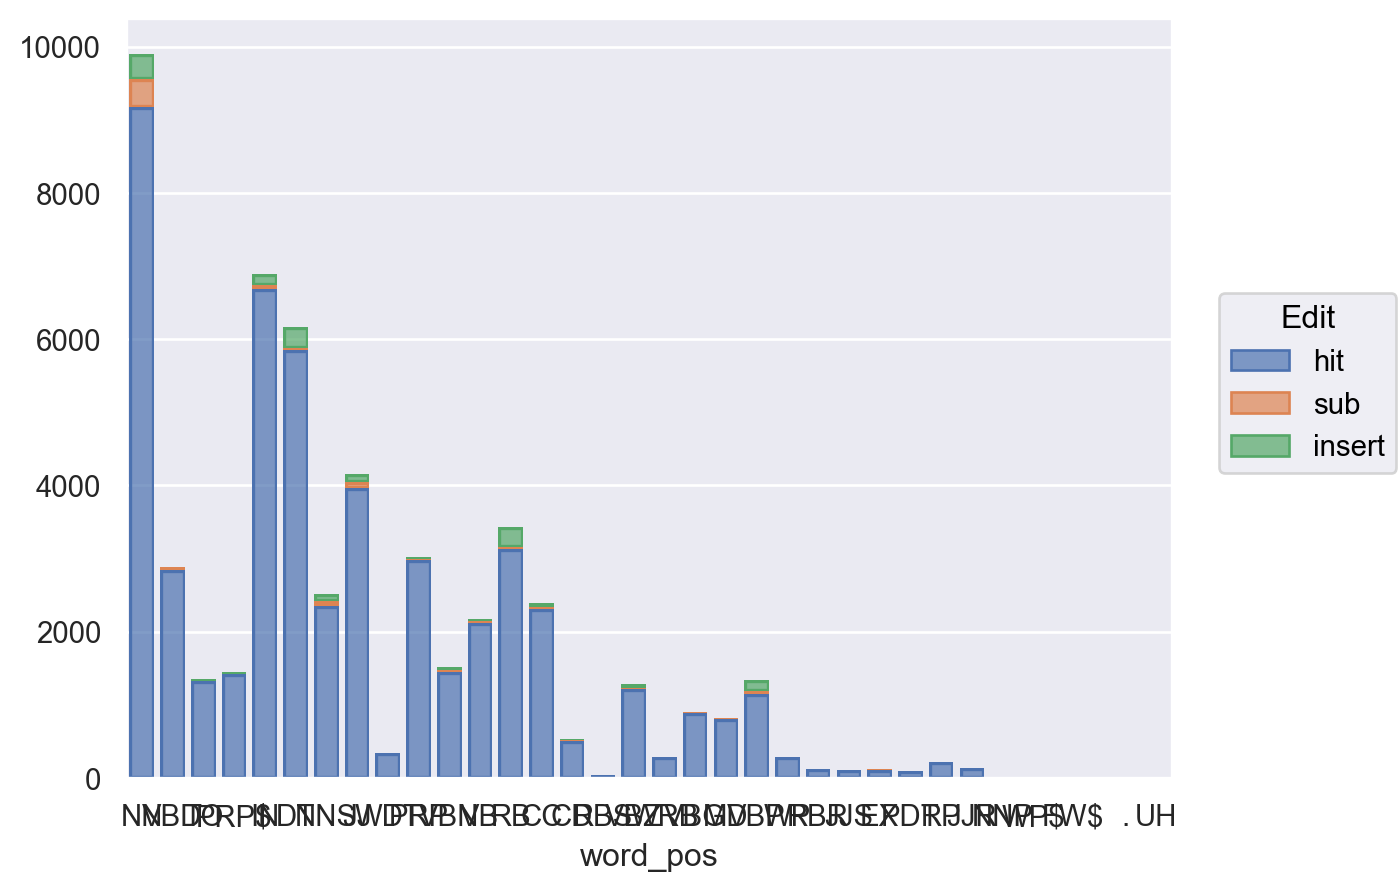

In [117]:
df['Edit']=df['edit_type'].map({0.0: "hit", 1.0: "sub", 3.0: "insert"})
Plot(df, x="word_pos", color="Edit").add(so.Bar(), so.Count(), so.Stack())

Visualize errors by Zipf freq for current, previous and next word.

In [118]:
zipf_df = df[['prev_word_zipf_freq', 'word_zipf_freq', 'next_word_zipf_freq', 'Edit']].melt(id_vars=['Edit'], value_name="Zipf freq")
zipf_df['variable'] = zipf_df['variable'].map({
    'prev_word_zipf_freq': 'Previous word',
    'word_zipf_freq': 'Current word',
    'next_word_zipf_freq': "Next word",
})
zipf_df

,Edit,variable,Zipf freq
0,hit,Previous word,7.682224
1,hit,Previous word,3.470000
2,hit,Previous word,4.820000
3,hit,Previous word,7.430000
4,hit,Previous word,6.140000
...,...,...,...
163375,hit,Next word,4.110000
163376,hit,Next word,4.990000
163377,hit,Next word,4.690000
163378,hit,Next word,4.730000


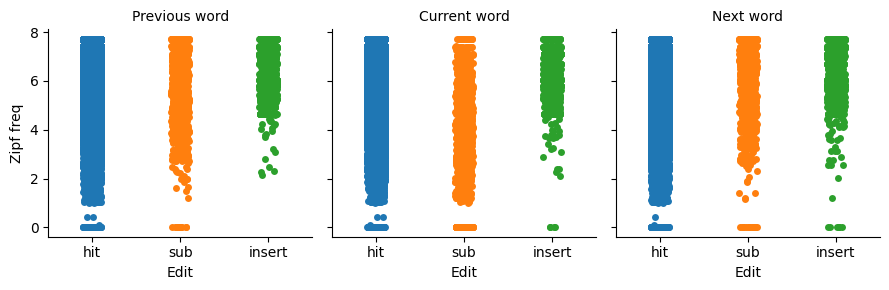

In [119]:
g=sns.FacetGrid(zipf_df, col='variable', hue='Edit')
g.map_dataframe(sns.stripplot, x='Edit', y='Zipf freq' )
g.set_titles(col_template="{col_name}")
# g.set_ylabel("Zipf frequency")
plt.show()

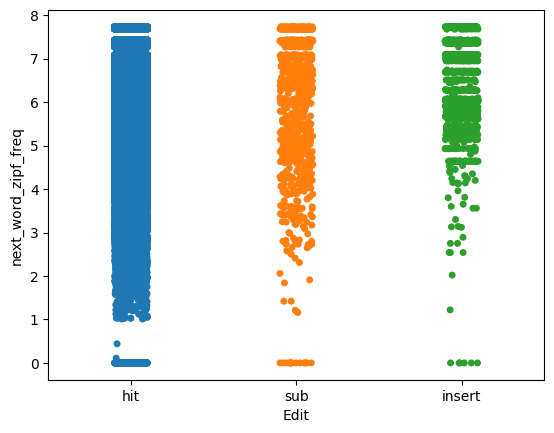

In [120]:
sns.stripplot(df, x='Edit', y='next_word_zipf_freq', hue='Edit')
plt.show()

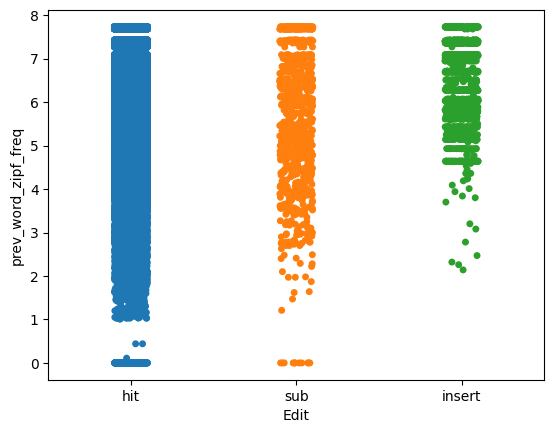

In [121]:
sns.stripplot(df, x='Edit', y='prev_word_zipf_freq', hue='Edit')
plt.show()

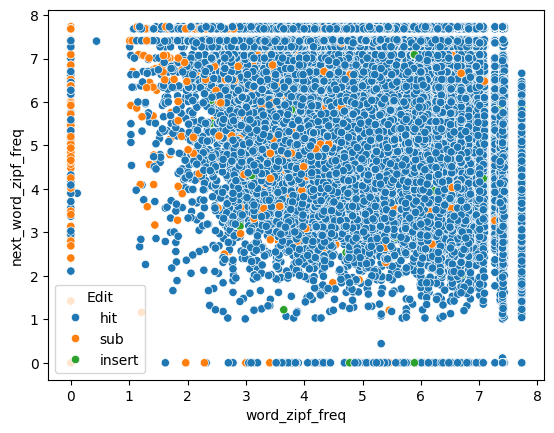

In [122]:
sns.scatterplot(df, x='word_zipf_freq', y='next_word_zipf_freq', hue='Edit')
plt.show()

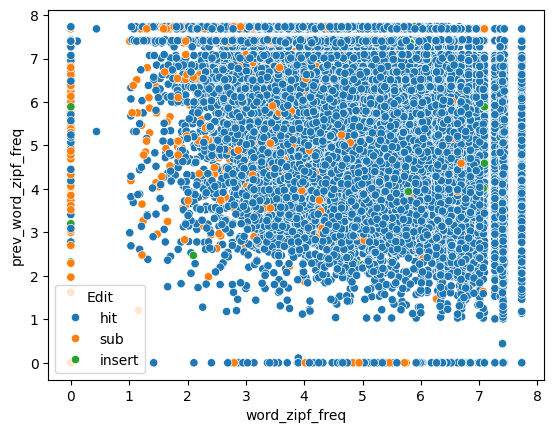

In [123]:
sns.scatterplot(df, x='word_zipf_freq', y='prev_word_zipf_freq', hue='Edit')
plt.show()

In [124]:
df[['prev_word_zipf_freq', 'word_zipf_freq', 'next_word_zipf_freq']].corr()

,prev_word_zipf_freq,word_zipf_freq,next_word_zipf_freq
prev_word_zipf_freq,1.000000,-0.131469,-0.009694
word_zipf_freq,-0.131469,1.000000,-0.193032
next_word_zipf_freq,-0.009694,-0.193032,1.000000


In [125]:
df['is_insert']=df['edit_type']==

SyntaxError: invalid syntax (1840913997.py, line 1)

In [ ]:
edits_per_word = df.groupby("word")['edit_type'].value_counts().unstack()
edits_per_word=edits_per_word.rename(columns={0.0: 'hit', 1.0: 'sub', 3.0: 'insert'})
edits_per_word=edits_per_word.reset_index()
edits_per_word=edits_per_word.melt(id_vars='word')
edits_per_word=edits_per_word.fillna(0)
edits_per_word

,word,edit_type,value
0,$150,hit,1.0
1,$250000,hit,1.0
2,$300,hit,1.0
3,$60,hit,1.0
4,.,hit,0.0
...,...,...,...
24085,zest,insert,0.0
24086,zion,insert,0.0
24087,zoology,insert,0.0
24088,zora,insert,0.0


In [ ]:
edits_per_word['value'].describe()

count    24090.000000
mean         2.260689
std         34.080268
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       3449.000000
Name: value, dtype: float64

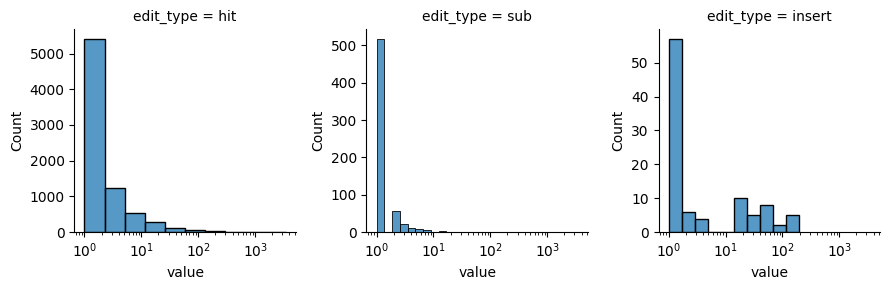

In [ ]:
g=sns.FacetGrid(edits_per_word, col='edit_type', sharex=True, sharey=False)
g.map_dataframe(sns.histplot, x='value', bins=10, log_scale=True)
# plt.xscale('log')
# plt.yscale('log')
plt.show()

Add total counts per word, then calculate percent of each edit type

In [ ]:
edits_per_word['total']=0
for word in edits_per_word['word'].unique():
    word_mask = edits_per_word['word']==word
    edits_per_word.loc[word_mask, 'total']=edits_per_word.loc[word_mask, 'value'].sum()
edits_per_word.head()

,word,edit_type,value,total
0,$150,hit,1.0,2
1,$250000,hit,1.0,1
2,$300,hit,1.0,1
3,$60,hit,1.0,1
4,.,hit,0.0,5


In [ ]:
edits_per_word['pcnt']=edits_per_word['value']/edits_per_word['total']
edits_per_word.head()

,word,edit_type,value,total,pcnt
0,$150,hit,1.0,2,0.5
1,$250000,hit,1.0,1,1.0
2,$300,hit,1.0,1,1.0
3,$60,hit,1.0,1,1.0
4,.,hit,0.0,5,0.0


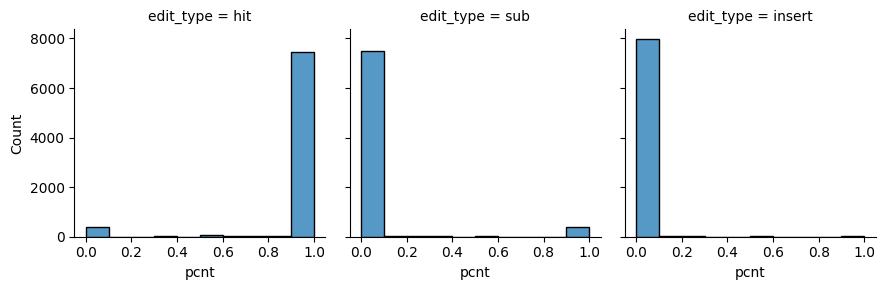

In [ ]:
g=sns.FacetGrid(edits_per_word, col='edit_type', sharey=True, sharex=True)
g.map_dataframe(sns.histplot, x='pcnt', bins=10)

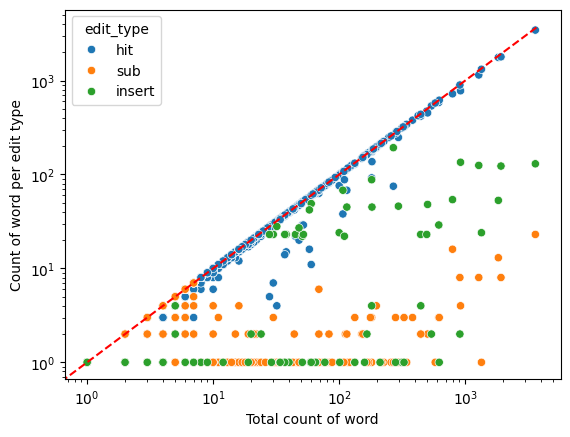

In [ ]:
g=sns.scatterplot(edits_per_word, x='total', y='value', hue='edit_type')
g.set_xlabel("Total count of word")
g.set_ylabel("Count of word per edit type")

lims = g.get_xlim()
g.plot(lims, lims, color='red', linestyle='dashed')

plt.xscale('log')
plt.yscale('log')

plt.show()